## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - Shiptracks

***erddapy requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)
***gmt-python requires python 3.6***

### connecting and basic information

In [57]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://krafla.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [58]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='argos'))

In [59]:
argos = df['Dataset ID'].values
print(argos)

['2015_Argos_Drifters' '2016_Argos_Drifters' '2017_Argos_Drifters'
 '2018_Argos_Drifters']


In [60]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [61]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]

In [62]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['trajectory_id']) 
common_variables

{'latitude', 'longitude', 'sst', 'strain', 'time', 'trajectory_id', 'voltage'}

In [63]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://krafla.pmel.noaa.gov:8080/erddap/tabledap/2015_Argos_Drifters.csv?sst,time,trajectory_id,voltage,strain,longitude,latitude&longitude>=0&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1420848000.0&time<=1547078400.0


In [64]:
from requests.exceptions import HTTPError

dfs = {}
for float in argos:
    print(float)
    try:
        e = ERDDAP(server=server_url,
            dataset_id=float,
            protocol='tabledap',
            response='csv',
            variables=common_variables,
            constraints=constraints
        )

        dfs.update({float: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except HTTPError:
        print('Failed to generate url {}'.format(float))
        continue


2015_Argos_Drifters
2016_Argos_Drifters
2017_Argos_Drifters
2018_Argos_Drifters


In [65]:
for float, df in dfs.items():
    print(float, df.groupby('trajectory_id').groups.keys())

2015_Argos_Drifters dict_keys([122533, 122537, 122542, 122843, 122845, 122846, 122847, 136859, 136860, 136861, 136862, 136863, 136864, 136865, 136866, 136867, 136868, 136869, 136870, 136871, 136873, 136874, 148276, 148277, 148278, 148279])
2016_Argos_Drifters dict_keys([136861, 136864, 136865, 136872, 136874, 148276, 148277, 148279])
2017_Argos_Drifters dict_keys([122537, 122540, 122541, 122542, 136860, 136863, 136866, 136867, 136868, 136869, 136872, 145474, 148276, 148277])
2018_Argos_Drifters dict_keys([122542, 136863, 136866, 136867, 136868, 136869, 145474, 148276])


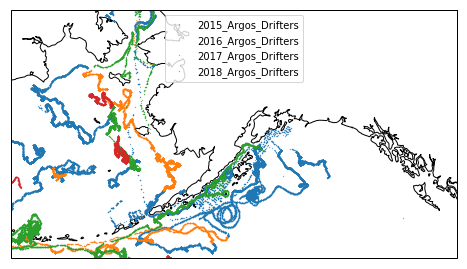

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 66]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Testing gmt-python as alternative plotting platform over cartopy or basemap

In [67]:
import gmt

In [68]:
fig = gmt.Figure()

fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

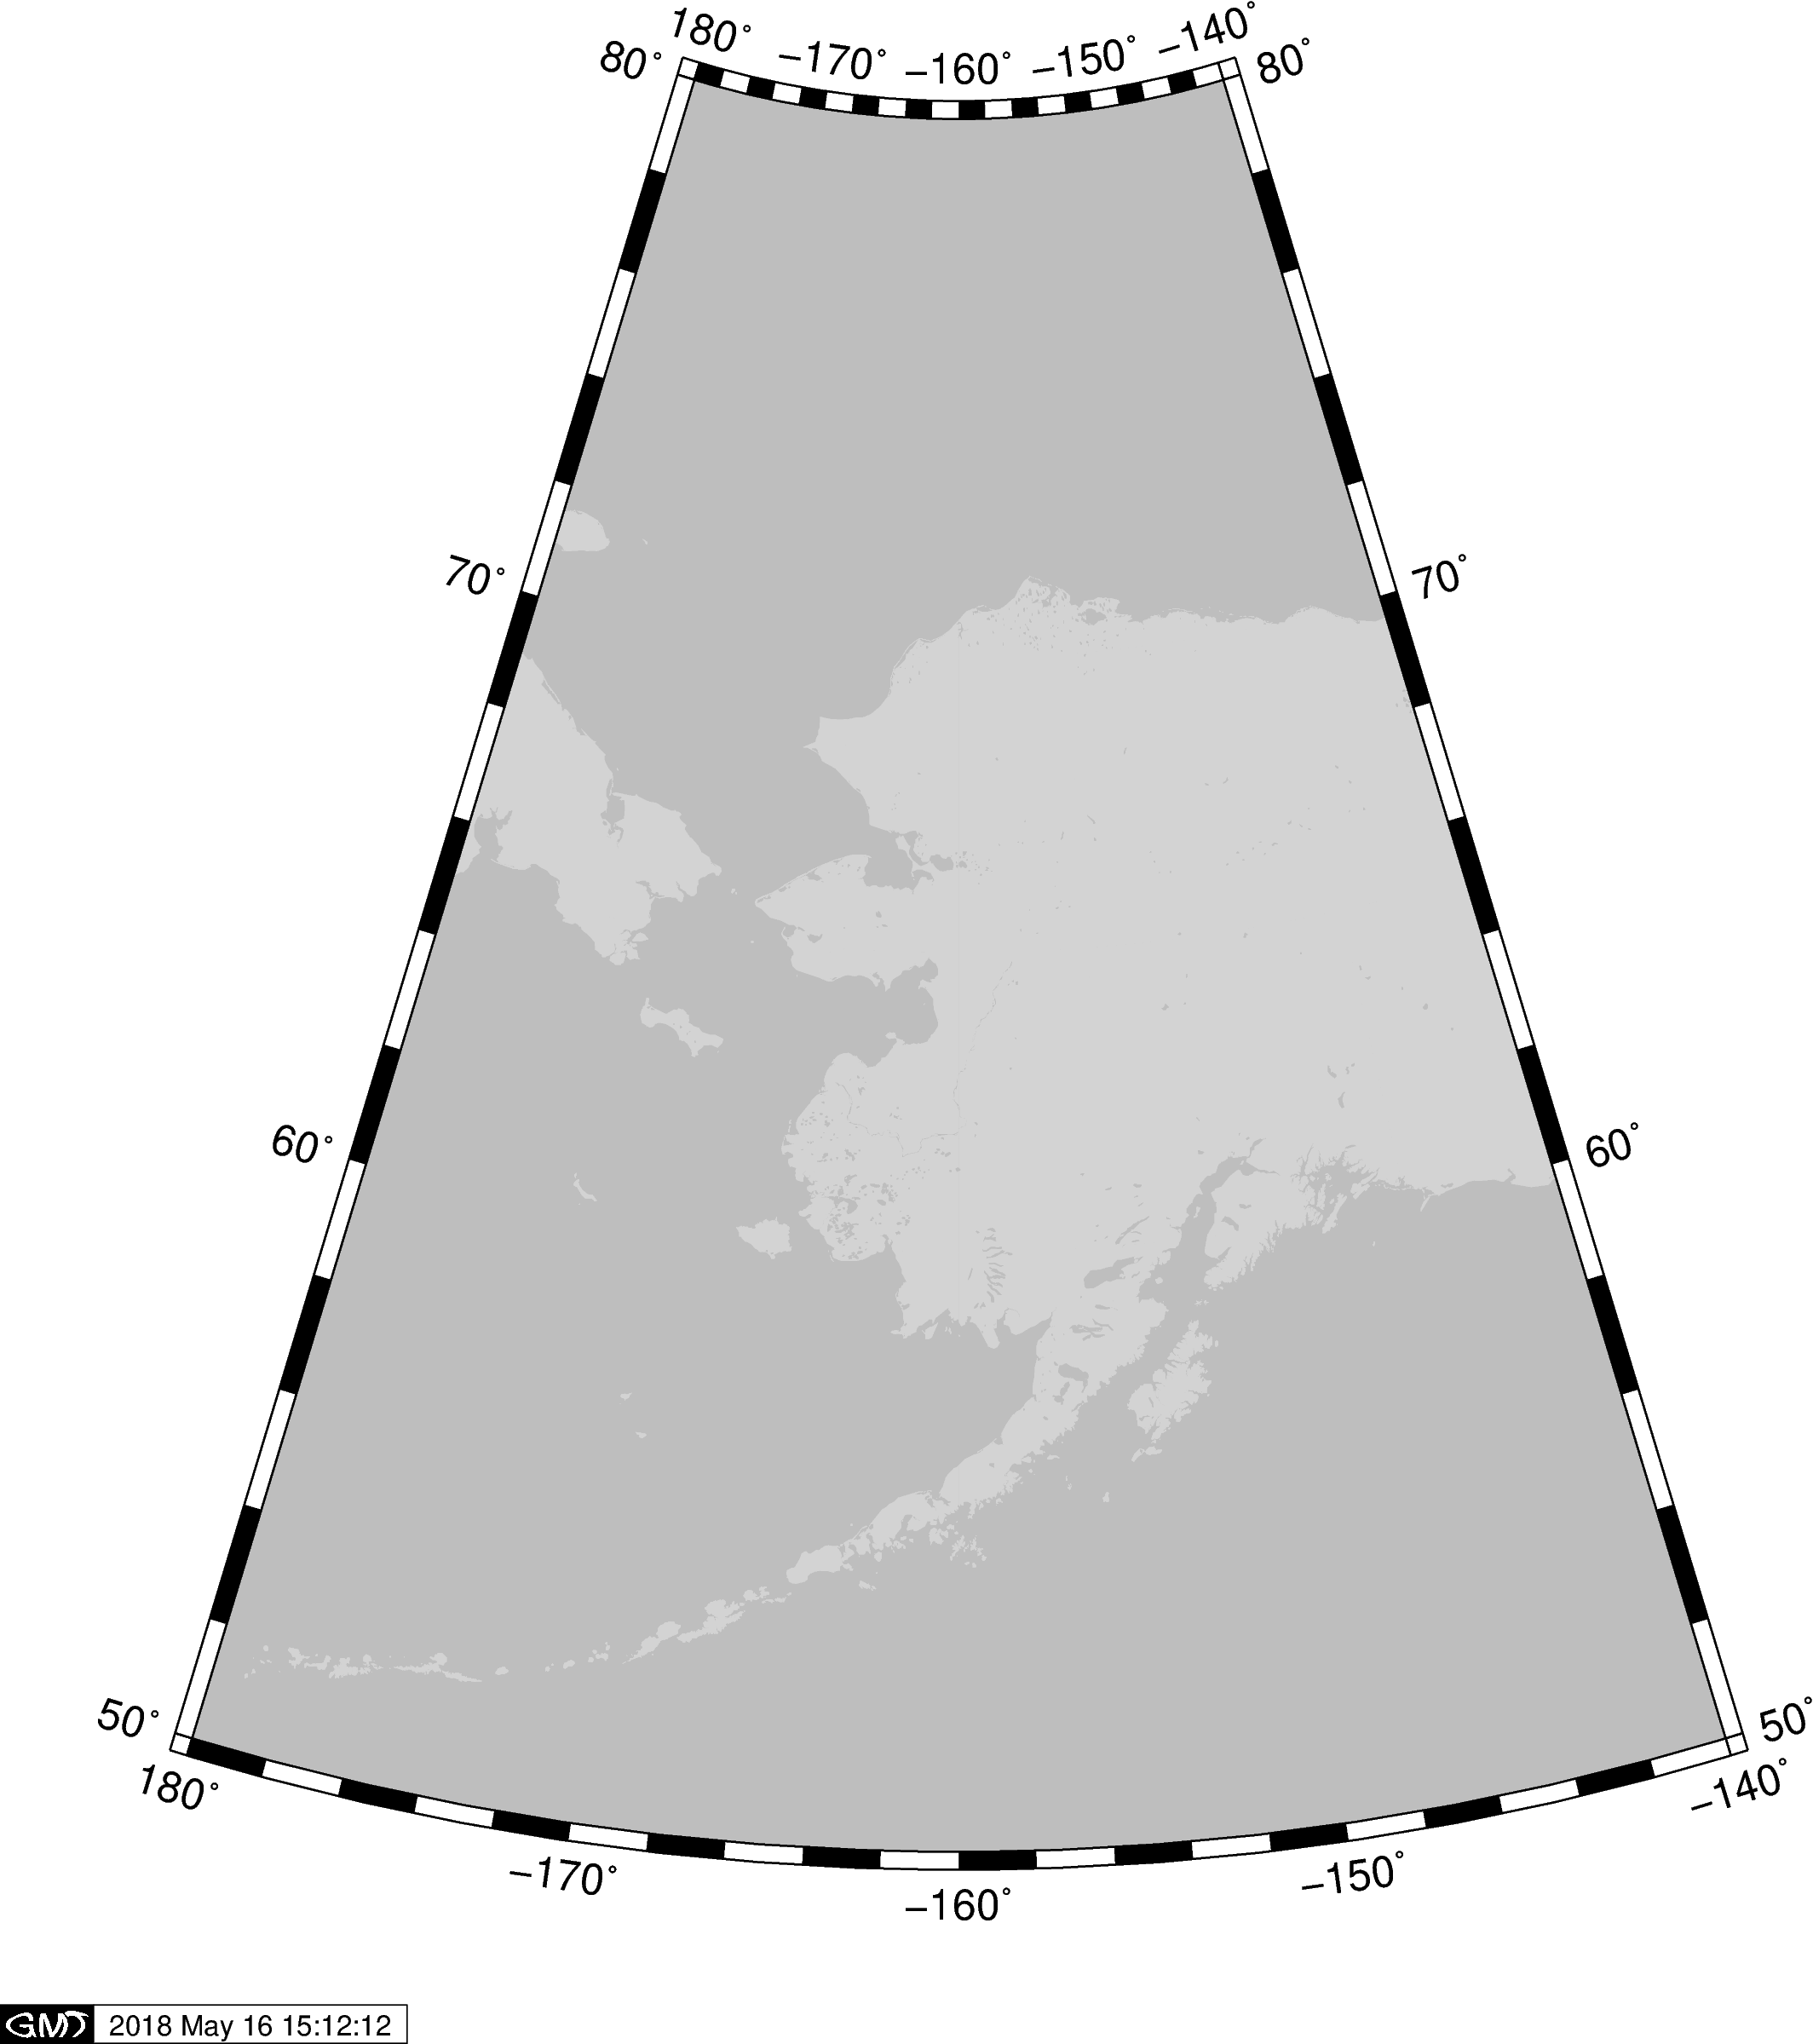

In [69]:
fig.show()

In [70]:
dfg = dfs['2017_Argos_Drifters'].groupby('trajectory_id')
dfg.groups.keys()

dict_keys([122537, 122540, 122541, 122542, 136860, 136863, 136866, 136867, 136868, 136869, 136872, 145474, 148276, 148277])

In [71]:
#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray']
count=0
for traj in dfg.groups.keys():
    fig.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red
black
blue
green
cyan
yellow
orange
lightred
lightgray
lightblue
lightgreen
lightyellow
brown
darkgray


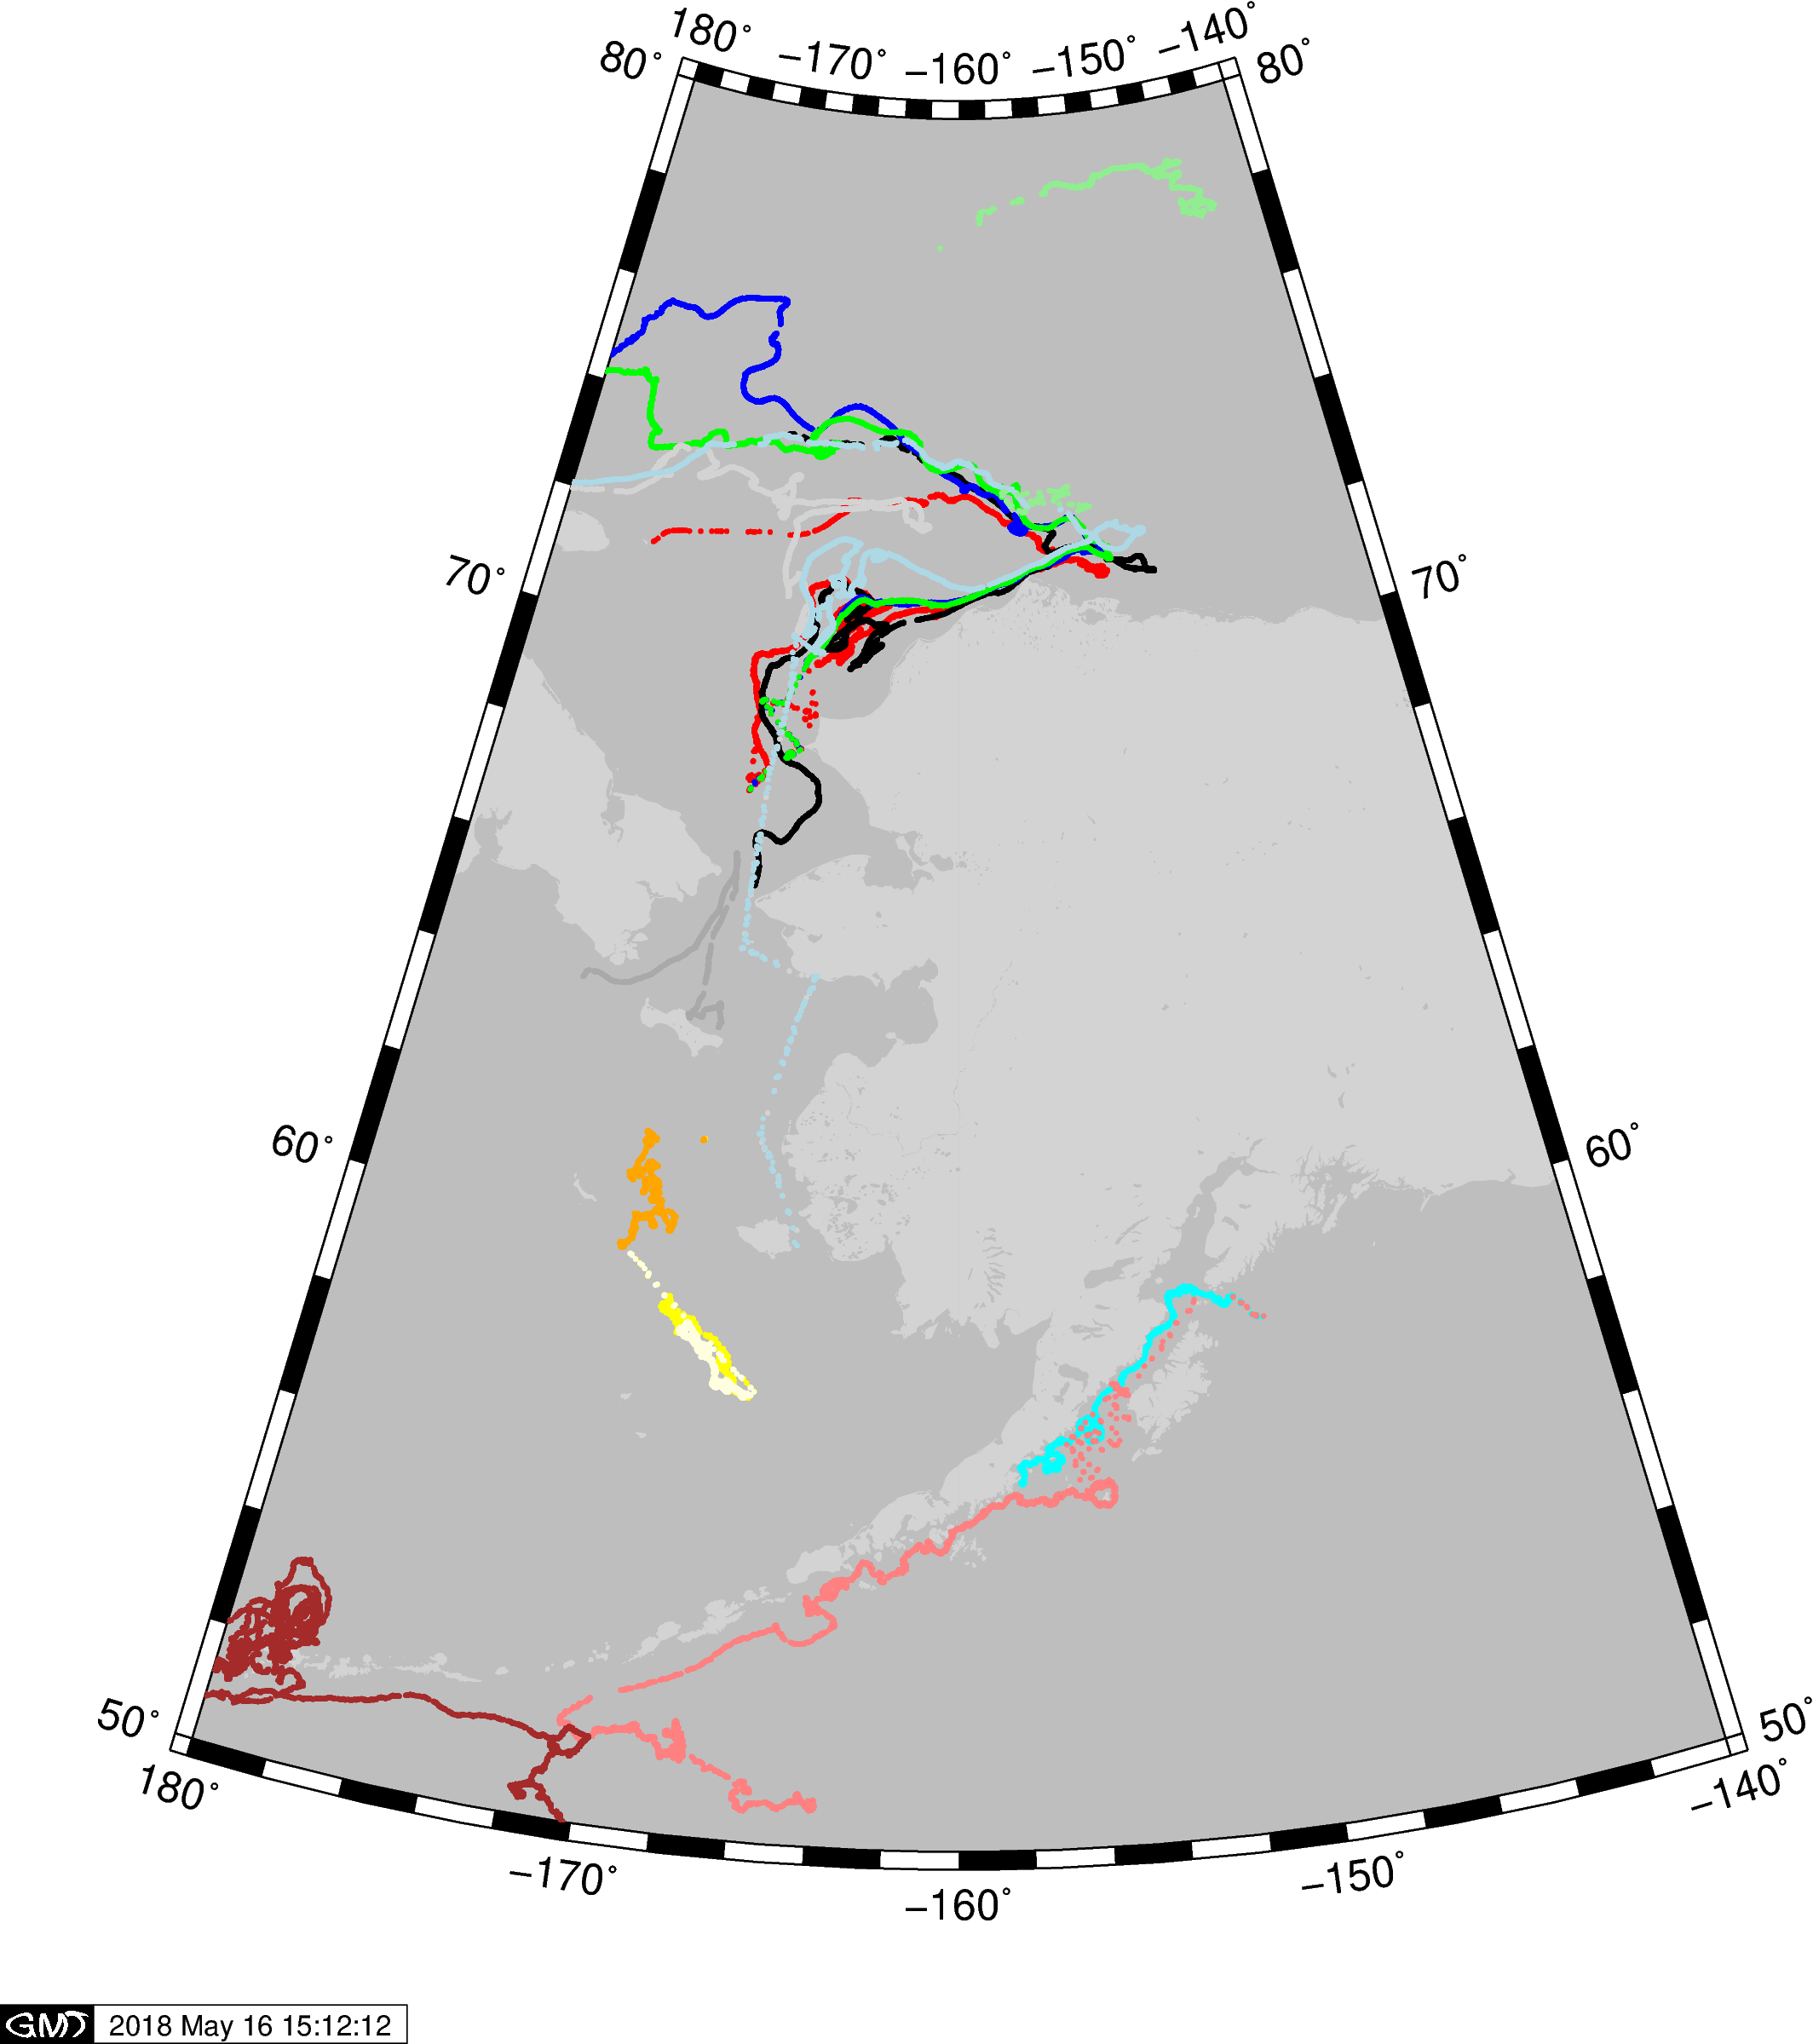

In [72]:
fig.show()

In [46]:
#color by year
clist=['red','black','blue','green','cyan','yellow','orange','lightred',
      'lightblue','lightgreen']
count=0
for ship, df in dfs.items():
    fig.plot(x=df.longitude, y=df.latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red
black
blue
green


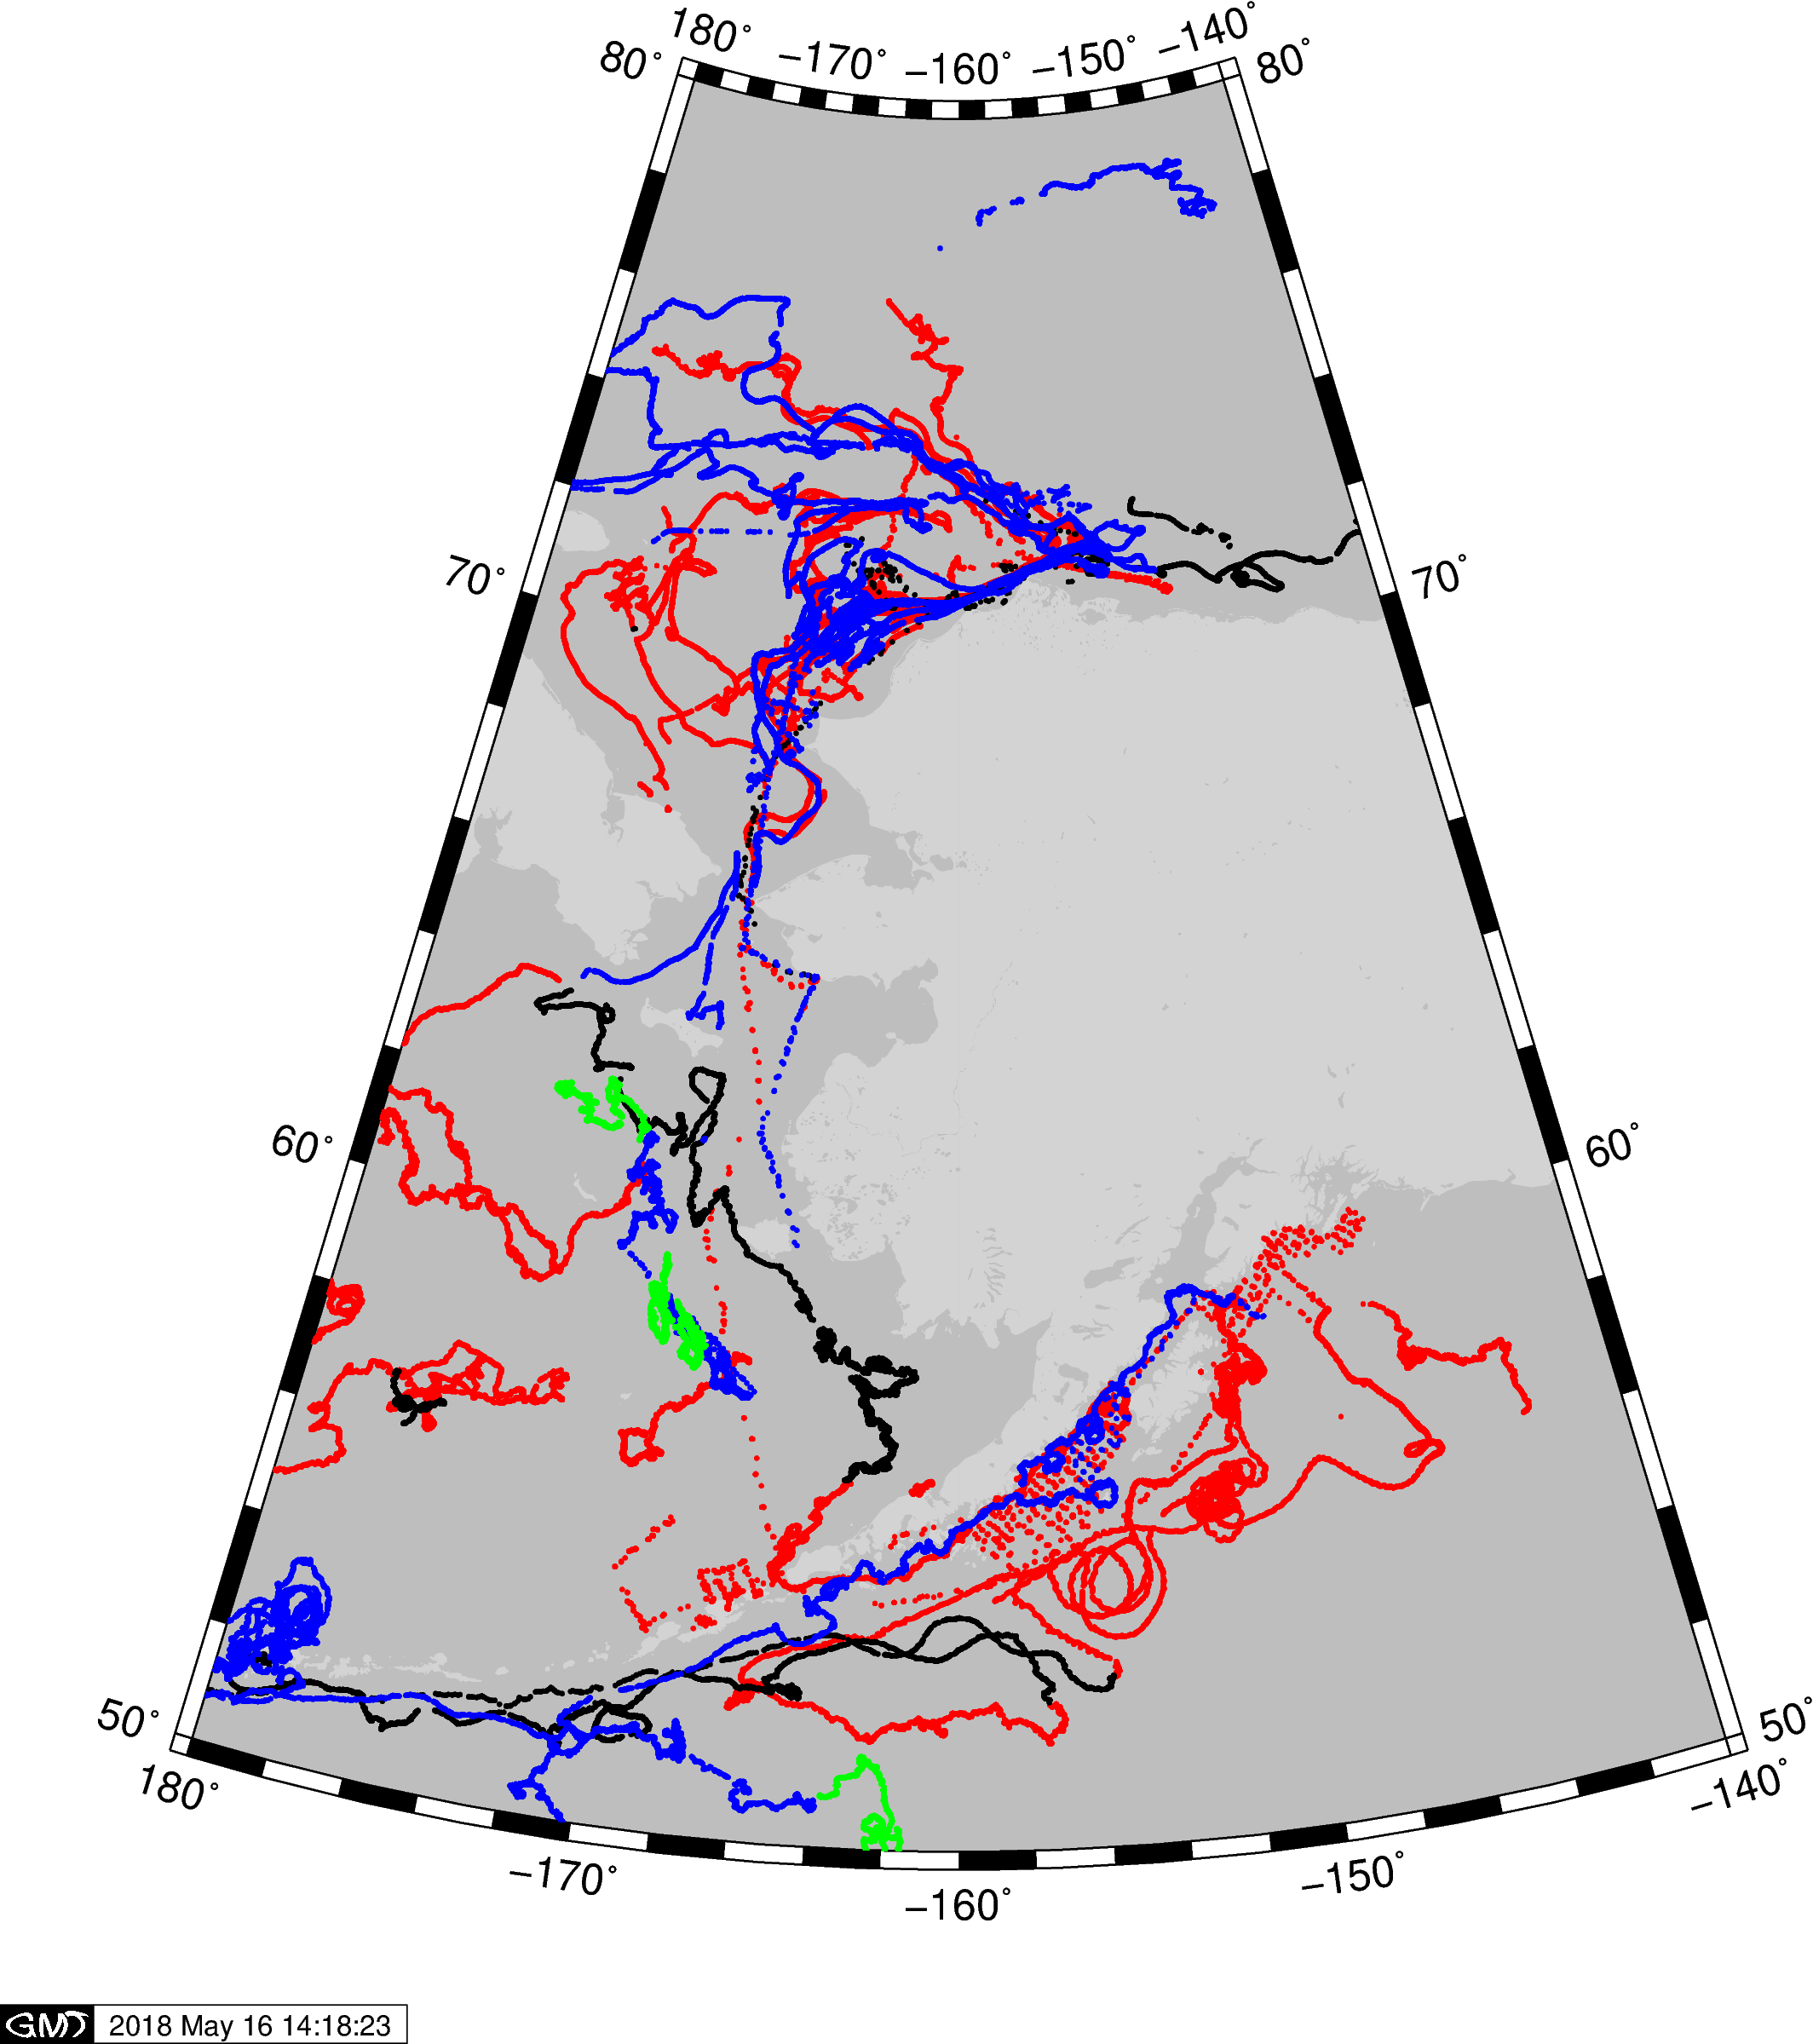

In [26]:
fig.show()

In [27]:
fig1 = gmt.Figure()

fig1.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

Using the cmocean colormaps for gmt found at http://soliton.vm.bytemark.co.uk/pub/cpt-city/cmocean/ (these must be installed in the {conda}/{gmt_env}/share/gmt/cpt/ path where conda is the path to your conda installation and gmt_env is the environment gmt is running in)

In [29]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


/Users/bell/anaconda2/envs/gmt-python/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


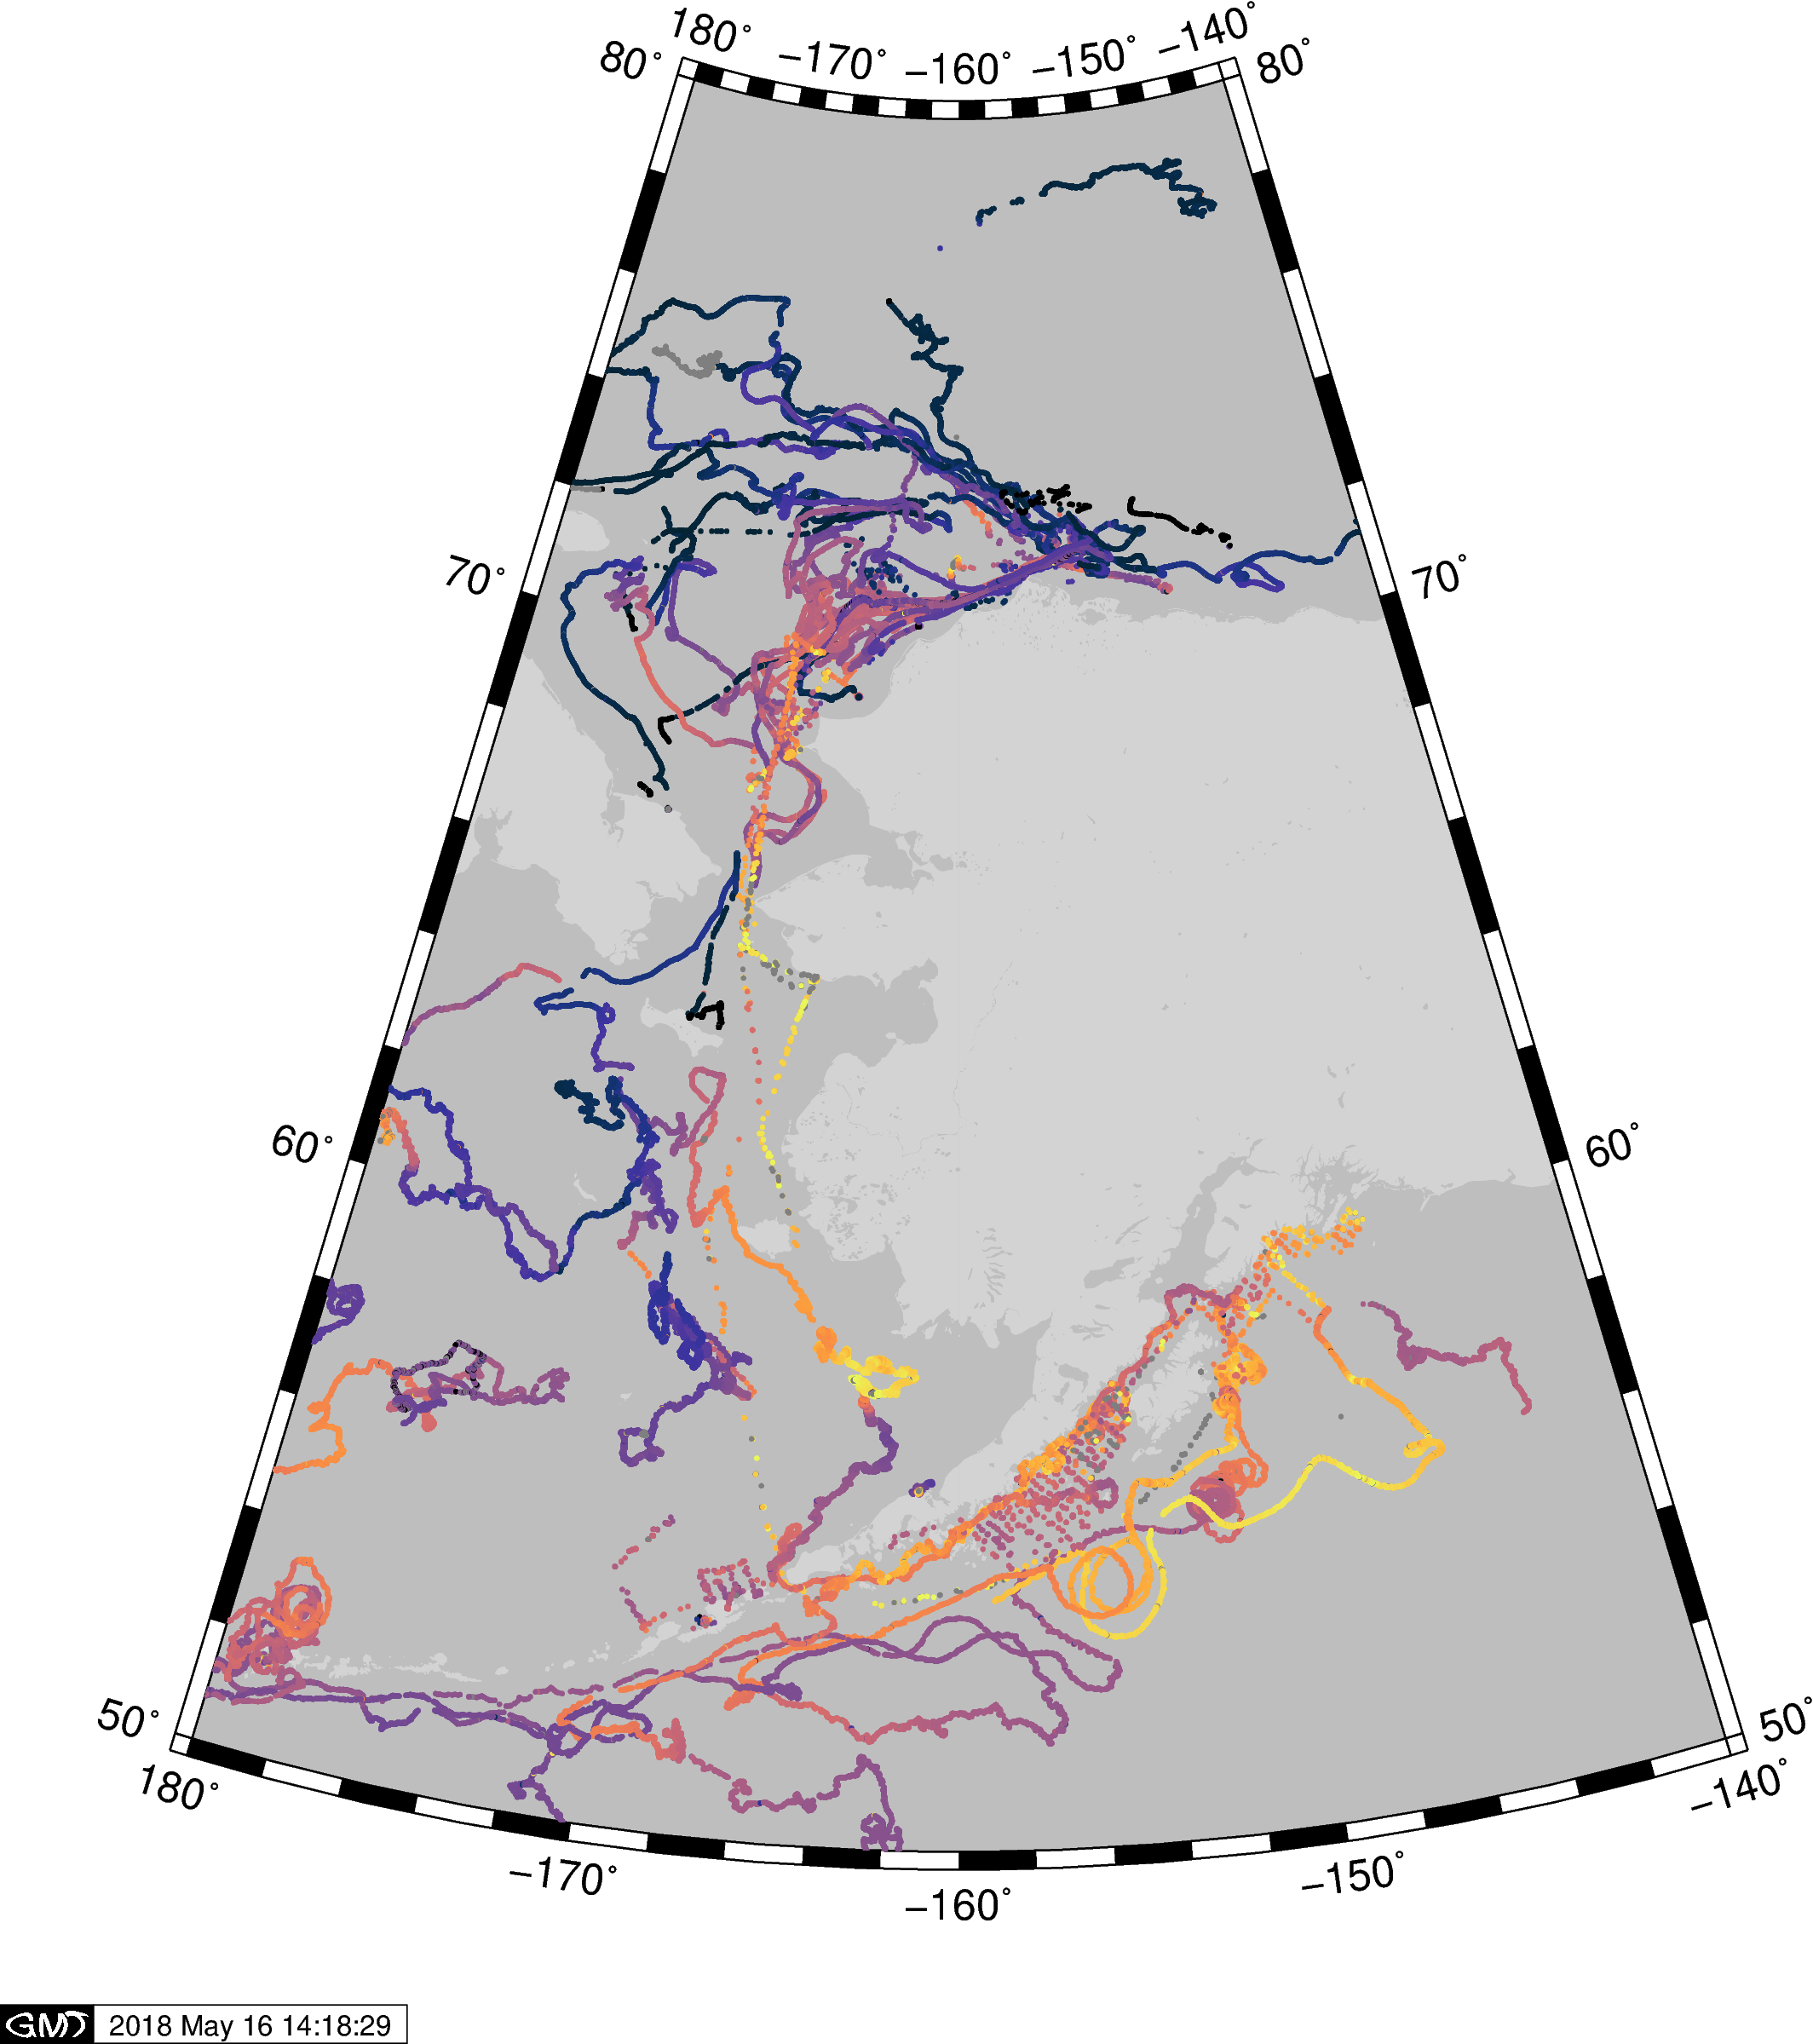

In [30]:
fig1.show()

In [31]:
dfmiss

,sst,trajectory_id,voltage,strain,longitude,latitude
time,,,,,,
2018-01-01 00:25:00,-2.00,122542,14.2,0.0,517.896,74.259
2018-01-01 00:37:00,-2.00,122542,14.2,0.0,517.892,74.259
2018-01-01 01:25:00,-2.00,122542,14.2,1.0,517.887,74.262
2018-01-01 01:50:00,-2.00,122542,14.2,1.0,517.892,74.264
2018-01-01 02:06:00,-2.00,122542,14.2,0.0,517.893,74.264
2018-01-01 02:17:00,-2.00,122542,14.2,0.0,517.895,74.264
2018-01-01 03:33:00,-2.00,122542,14.2,1.0,517.897,74.269
2018-01-01 03:47:00,-2.00,122542,14.2,1.0,517.899,74.269
2018-01-01 03:57:00,-2.00,122542,14.2,1.0,517.902,74.269
